In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns

In [2]:
task1_file = pd.read_table('fail1.txt', sep='\t')
task1_file['assigned_ts'] = pd.to_datetime(task1_file['assigned_ts'])
task1_file['closed_ts'] = pd.to_datetime(task1_file['closed_ts'])
T1F = task1_file.copy()

В начале хочется получить базовое представление о данных, с которыми мы работаем

In [3]:
T1F

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50
...,...,...,...,...,...
701822,login766,195656026.0,1.0,2017-05-15 15:53:27,2017-05-15 16:16:56
701823,login766,195656174.0,1.0,2017-05-15 15:53:33,2017-05-15 16:21:53
701824,login766,195656466.0,1.0,2017-05-15 15:53:38,2017-05-15 16:23:41
701825,login766,195656336.0,3.0,2017-05-15 15:54:18,2017-05-15 16:32:11


In [4]:
len(T1F['login'].unique())

767

In [5]:
len(T1F['tid'].unique())

635044

In [6]:
T1F['Microtasks'].mean()

3.254390326960918

In [7]:
T1F['Microtasks'].max()

50.0

In [8]:
(T1F['closed_ts'] - T1F['assigned_ts']).mean()

Timedelta('0 days 00:32:09.659941837')

In [9]:
(T1F['closed_ts'] - T1F['assigned_ts']).max()

Timedelta('23 days 15:32:58')

Достаточно долго, кажется

In [10]:
(T1F['closed_ts'] - T1F['assigned_ts']).min()

Timedelta('-1 days +23:47:51')

Отрицательное значение выглядит странно, скорее всего это ошибка

Следующее выражение убирает строки, когда задание считается выполненым еще до того, как его назначили

In [11]:
T1F = T1F.loc[T1F['assigned_ts'] <= T1F['closed_ts']]

In [12]:
T1F['closed_ts'].max()

Timestamp('2017-06-01 23:59:58')

In [13]:
T1F['assigned_ts'].min()

Timestamp('2017-04-20 00:00:00')

In [14]:
T1F['closed_ts'].max() - T1F['assigned_ts'].min()

Timedelta('42 days 23:59:58')

Удалим дублирующиеся строки

In [15]:
T1F = T1F.drop_duplicates(['login', 'tid', 'assigned_ts', 'closed_ts'])

Посмотрим на распределение, сколько времени в среднем тратит каждый асессор на микротаск

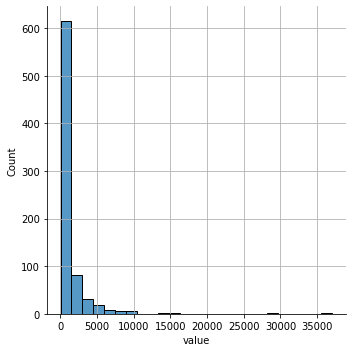

In [16]:
df = pd.DataFrame(columns=['value'])
for assessor in T1F['login'].unique():
    AUpload = T1F[T1F['login'] == assessor]
    df = df.append(pd.DataFrame(((AUpload['closed_ts'] - AUpload['assigned_ts']) / AUpload['Microtasks']).mean().total_seconds(), index=[assessor], columns=['value']))
    
ax = sns.displot(df['value'], bins=25)
plt.grid()
plt.show()

Получается время свыше 10000 секунд встречается крайне редко

Постараемся отчистить данные от ошибок со слишком большими значениями. Идея следующей функции в том, что мы удаляем значеия, которые больше чем в **100** раз превышают среднее для этого задания

In [23]:
def del_maxwrong_value(dataframe):
    for login in dataframe['login'].unique():
        currentLogin = dataframe.loc[dataframe['login'] == login]
        Max = dataframe.loc[((dataframe['closed_ts'] - dataframe['assigned_ts']) / dataframe['Microtasks']) == ((currentLogin['closed_ts'] - currentLogin['assigned_ts']) / currentLogin['Microtasks']).max()]
        Max = Max.loc[Max['login'] == login]
        df_tid = dataframe.loc[dataframe['tid'] == Max['tid'].iloc[0]]
        df_tid = df_tid.loc[df_tid.index != Max.index.unique()[0]]
        if df_tid.shape[0] > 1 and ((Max['closed_ts'] - Max['assigned_ts']) / Max['Microtasks']).mean().total_seconds() > 100 * ((df_tid['closed_ts'] - df_tid['assigned_ts']) / df_tid['Microtasks']).mean().total_seconds():
            dataframe = dataframe.loc[dataframe.index != Max.index.item()]
    return dataframe

In [24]:
T1F = del_maxwrong_value(T1F)

Теперь уберем пересечения, т.е. когда асессор не закончив одно задание получает следующее. Мы предполагаем, что асессор не трудится над несколькими заданиями одновременно. Следовательно его фактическое время работы меньше

In [19]:
frames = []
for assessor in T1F['login'].unique():
    AUpload = T1F[T1F['login'] == assessor]
    AUpload.sort_values(by='assigned_ts', inplace=True)
    AUpload.reset_index(drop=True, inplace=True)
    index = 0
    if AUpload.shape[0] == 1:
        frames.append(AUpload)
        continue
    else:
        for close_time in AUpload['closed_ts']:
            index+=1        
            if close_time > AUpload['assigned_ts'].loc[index] and close_time < AUpload['closed_ts'].loc[index]:
                AUpload['assigned_ts'].loc[index] = close_time
            if index + 1 == AUpload.shape[0]:
                break 
        frames.append(AUpload)

T1FNew = pd.concat(frames, ignore_index=True)    
T1FNew.reset_index(drop=True, inplace=True)
T1FNew

<ipython-input-19-cfc5cf2295a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AUpload.sort_values(by='assigned_ts', inplace=True)
c:\users\root\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\root\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:28:29,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 13:13:56,2017-04-20 13:14:50
...,...,...,...,...,...
679953,login766,195656026.0,1.0,2017-05-15 16:07:09,2017-05-15 16:16:56
679954,login766,195656174.0,1.0,2017-05-15 16:16:56,2017-05-15 16:21:53
679955,login766,195656466.0,1.0,2017-05-15 16:21:53,2017-05-15 16:23:41
679956,login766,195656336.0,3.0,2017-05-15 16:23:41,2017-05-15 16:32:11


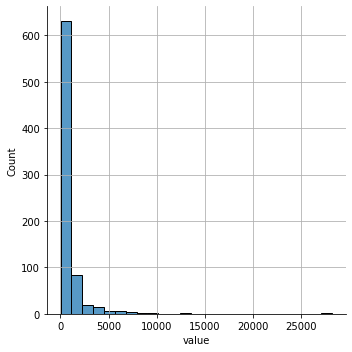

In [20]:
dfNew = pd.DataFrame(columns=['value'])
for assessor in T1FNew['login'].unique():
    AUpload = T1FNew[T1FNew['login'] == assessor]
    dfNew = dfNew.append(pd.DataFrame(((AUpload['closed_ts'] - AUpload['assigned_ts']) / AUpload['Microtasks']).mean().total_seconds(), index=[assessor], columns=['value']))
    
ax = sns.displot(dfNew['value'], bins=25)
plt.grid()
plt.show()

Как видно из распределения время, потраченное на решение микротасков, снизилось

In [21]:
dfNew['value'].mean() / 30

25.99233915015211

В итоге я считаю справедливой оплату в размере **26N** за один микротаск

In [22]:
df['value'].mean() / 30

38.46027615958279

In [38]:
pd.set_option('display.max_rows', 500)